In [1]:
import os
import sys
import glob
import pickle
import yaml
from tqdm import tqdm
import itertools

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
sys.path.append("..")

In [3]:
import utils_io
import metrics

In [4]:
SAVE = False

In [5]:
#results_dir = "../results/small/passive"
results_dir = "../results/passive"

In [6]:
config_files = glob.glob(f"{results_dir}/*/*/*.yaml")
config_files

['../results/passive/xvector_2022-02-12/02-20-27/config_xvector_trimmed_2sec_ahc_plda.yaml',
 '../results/passive/xvector_2022-02-12/23-06-44/config_xvector_trimmed_2sec_ahc.yaml',
 '../results/passive/speechbrain_2022-02-12/01-47-25/config_speechbrain_trimmed_2sec_ahc_plda.yaml',
 '../results/passive/speechbrain_2022-02-12/01-47-47/config_speechbrain_trimmed_2sec_vb_plda.yaml',
 '../results/passive/speechbrain_2022-02-11/23-31-49/config_speechbrain_trimmed_2sec_ahc.yaml',
 '../results/passive/speechbrain_2022-02-11/17-00-32/config_speechbrain_trimmed_2sec_ahc_plda.yaml',
 '../results/passive/speechbrain_2022-02-11/16-49-53/config_speechbrain_trimmed_2sec_vb_plda.yaml',
 '../results/passive/speechbrain_2022-02-11/16-49-26/config_speechbrain_trimmed_2sec_ahc.yaml',
 '../results/passive/xvector_2022-02-11/17-03-31/config_xvector_trimmed_2sec_ahc_plda.yaml',
 '../results/passive/xvector_2022-02-11/16-53-25/config_xvector_trimmed_2sec_ahc.yaml',
 '../results/passive/xvector_2022-02-11/16-5

In [7]:
AVERAGE_PER_CLUSTER = True


results_dict = {}

for config_file in tqdm(config_files):
    
    print(os.path.basename(config_file).split('.')[0])
    
    config_dir = os.path.dirname(config_file)
    config = yaml.load(open(config_file), Loader=yaml.FullLoader)
    
    embeddings_name = config["embeddings_name"] # ['clova', 'speechbrain', 'xvector']
    embeddings_type = config["embeddings_type"]

    score_type = config["score_type"] # ['cos_emb_avg', 'cos_sc_avg', 'plda_sph', 'plda_diag']
    by_the_book = config["by_the_book"] # plda scoring
    preprocessing_name = config["preprocessing_name"]
    recognizer = config["recognizer"] # ['exp_avg', 'memory'], use 'memory' for 'cos_sc_avg'
    sequential_updates = config["sequential_updates"]
    
    algorithm = config["params"]["algorithm"][0]
    
#     if embeddings_name in ["speechbrain", "clova"]:
#         continue
        
    run_name = f"{embeddings_name}_{embeddings_type}_{algorithm}"
#     if not sequential_updates:
#         run_name = f"{run_name}_offline"
#     if embeddings_name == "xvector" and by_the_book:
#         run_name = f"{run_name}_by-the-book"
    print(run_name)
    
    
    JER_list = []

    
#     thresholds = []


    params_dict = {"alpha": [], "Fa": [], "Fb": [], "algorithm": [], "threshold": []}
    
    for results_dir_iter in [dir_name for dir_name in glob.glob(f"{config_dir}/*") if os.path.isdir(dir_name)]:
        #print(results_dir_iter)
        
        try:
            with open(f"{results_dir_iter}/params.pickle", "rb") as params_file:
                params = pickle.load(params_file)
            #print(params)
        except:
            print(f"Failed to load params for {results_dir_iter}")
            continue
            
            
#         thresholds += [params["threshold"]]

        threshold = params["threshold"]
        
        for key in params_dict.keys():
            val = params.get(key, np.nan)
            val = val if val is not None else np.nan
            params_dict[key].append(val)
                

        jers_all = []
        for file_results in glob.glob(f"{results_dir_iter}/*.txt"):
            data = utils_io.read_lines_file(file_results)
            scores, labels_true, labels_pred = list(zip(*data))

            labels_pred_threshold = []
            for (score, label) in zip(scores, labels_pred):
                if float(score) > threshold:
                    labels_pred_threshold += [int(label)]
                else:
                    labels_pred_threshold += [-1]

            labels_true = np.array([int(idx) for idx in labels_true]) # !
            labels_pred_threshold = np.array(labels_pred_threshold)

            # compute JER
            jers = metrics.compute_jer(labels_pred_threshold, labels_true,
                                       return_individual=AVERAGE_PER_CLUSTER)
            if AVERAGE_PER_CLUSTER:
                jers_all += jers.tolist()
            else:
                jers_all += [jers]
                
        JER = np.mean(jers_all)
        JER_list += [JER]
        
        

    JER_list = np.array(JER_list)

    results_dict_run = {}
    results_dict_run['JER'] = JER_list
    results_dict_run['params'] = params_dict
    
    for key, val in params_dict.items():
        params_dict[key] = np.array(val)
    
    
    # sort
    params_dict = results_dict_run['params']
    
    thresholds = params_dict['threshold']
    idx_sort = np.argsort(thresholds)
    
    for key, val in results_dict_run.items():
        if isinstance(val, np.ndarray):
            results_dict_run[key] = val[idx_sort]
        elif isinstance(val, dict):
            for k, v in val.items():
                if isinstance(v, np.ndarray):
                    val[k] = v[idx_sort]
                else:
                    print("Error")
                    
    results_dict[run_name] = results_dict_run


  0%|          | 0/18 [00:00<?, ?it/s]

config_xvector_trimmed_2sec_ahc_plda
xvector_trimmed_2sec_ahc_plda_diag


  6%|▌         | 1/18 [00:12<03:26, 12.16s/it]

config_xvector_trimmed_2sec_ahc
xvector_trimmed_2sec_ahc


 11%|█         | 2/18 [19:49<3:05:58, 697.40s/it]

config_speechbrain_trimmed_2sec_ahc_plda
speechbrain_trimmed_2sec_ahc_plda_sph


 17%|█▋        | 3/18 [20:07<1:36:51, 387.40s/it]

config_speechbrain_trimmed_2sec_vb_plda
speechbrain_trimmed_2sec_vb_plda_sph


 22%|██▏       | 4/18 [1:46:34<8:52:30, 2282.20s/it]

config_speechbrain_trimmed_2sec_ahc
speechbrain_trimmed_2sec_ahc


 28%|██▊       | 5/18 [2:04:57<6:42:19, 1856.89s/it]

config_speechbrain_trimmed_2sec_ahc_plda
speechbrain_trimmed_2sec_ahc_plda_sph


 33%|███▎      | 6/18 [2:04:59<4:05:13, 1226.13s/it]

config_speechbrain_trimmed_2sec_vb_plda
speechbrain_trimmed_2sec_vb_plda_sph


 39%|███▉      | 7/18 [2:05:06<2:31:46, 827.83s/it] 

config_speechbrain_trimmed_2sec_ahc
speechbrain_trimmed_2sec_ahc


 44%|████▍     | 8/18 [2:05:09<1:34:10, 565.05s/it]

config_xvector_trimmed_2sec_ahc_plda
xvector_trimmed_2sec_ahc_plda_diag


 50%|█████     | 9/18 [2:05:11<58:20, 388.95s/it]  

config_xvector_trimmed_2sec_ahc
xvector_trimmed_2sec_ahc


 56%|█████▌    | 10/18 [2:05:13<35:57, 269.65s/it]

config_xvector_trimmed_2sec_vb_plda
xvector_trimmed_2sec_vb_plda_diag


 61%|██████    | 11/18 [2:05:24<22:12, 190.42s/it]

config_clova_2sec_vb_plda_sph
clova_2sec_vb_plda_sph


 67%|██████▋   | 12/18 [3:41:13<3:08:09, 1881.50s/it]

config_clova_2sec_ahc_plda
clova_2sec_ahc_plda_sph


 72%|███████▏  | 13/18 [3:41:35<1:49:50, 1318.08s/it]

config_clova_2sec_ahc
clova_2sec_ahc


 78%|███████▊  | 14/18 [4:09:31<1:35:04, 1426.13s/it]

config_clova_2sec_vb_plda_sph
clova_2sec_vb_plda_sph


 83%|████████▎ | 15/18 [4:09:39<49:56, 998.71s/it]   

config_clova_2sec_ahc_plda
clova_2sec_ahc_plda_sph


 89%|████████▉ | 16/18 [4:09:41<23:17, 698.65s/it]

config_clova_2sec_ahc
clova_2sec_ahc


 94%|█████████▍| 17/18 [4:09:44<08:09, 489.67s/it]

config_xvector_trimmed_2sec_vb_plda
xvector_trimmed_2sec_vb_plda_diag


100%|██████████| 18/18 [5:21:51<00:00, 1072.85s/it]


In [8]:
results_dict.keys()

dict_keys(['xvector_trimmed_2sec_ahc_plda_diag', 'xvector_trimmed_2sec_ahc', 'speechbrain_trimmed_2sec_ahc_plda_sph', 'speechbrain_trimmed_2sec_vb_plda_sph', 'speechbrain_trimmed_2sec_ahc', 'xvector_trimmed_2sec_vb_plda_diag', 'clova_2sec_vb_plda_sph', 'clova_2sec_ahc_plda_sph', 'clova_2sec_ahc'])

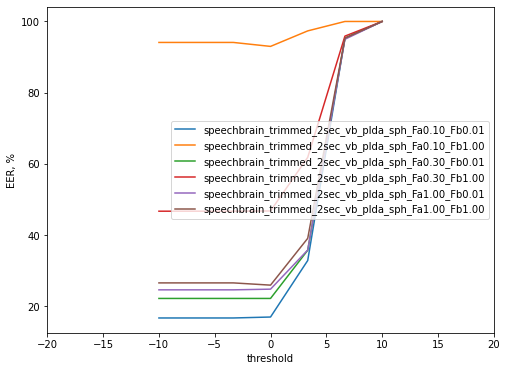

In [15]:
plt.figure(figsize=(8, 6))
plt.xlabel("threshold")
plt.ylabel("EER, %")
plt.xlim(-20, 20)




for run_name in ['speechbrain_trimmed_2sec_vb_plda_sph']:  # 
    
    results_dict_run = results_dict[run_name]
    params_dict = results_dict_run['params']
    Fa = params_dict["Fa"]
    Fb = params_dict["Fb"]
    
    for (fa, fb) in itertools.product(np.unique(Fa), np.unique(Fb)):
        
        mask = (Fa == fa) * (Fb == fb)


        thresholds = params_dict['threshold']

        JER = results_dict_run['JER']

        label = f"{run_name}_Fa{fa:.2f}_Fb{fb:.2f}"

        plt.plot(thresholds[mask], JER[mask], label=label);
        plt.legend() 
    
 
    
#plt.savefig("NAME", bbox_inches="tight") 

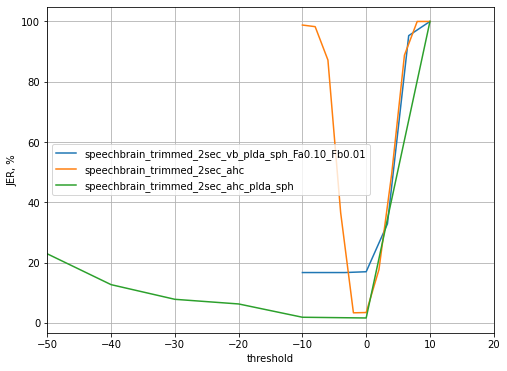

In [10]:
plt.figure(figsize=(8, 6))
plt.xlabel("threshold")
plt.ylabel("JER, %")
plt.xlim(-50, 20)
plt.grid() 


fa = 0.1
fb = 0.01

run_name = 'speechbrain_trimmed_2sec_vb_plda_sph'
    
results_dict_run = results_dict[run_name]
params_dict = results_dict_run['params']
Fa = params_dict["Fa"]
Fb = params_dict["Fb"]

mask = (Fa == fa) * (Fb == fb)

thresholds = params_dict['threshold']

JER = results_dict_run['JER']

label = f"{run_name}_Fa{fa:.2f}_Fb{fb:.2f}"

plt.plot(thresholds[mask], JER[mask], label=label);
plt.legend();


for run_name in ['speechbrain_trimmed_2sec_ahc', 'speechbrain_trimmed_2sec_ahc_plda_sph']:

    results_dict_run = results_dict[run_name]
    params_dict = results_dict_run['params']

    thresholds = params_dict['threshold']

    JER = results_dict_run['JER']

    label = f"{run_name}"

    plt.plot(thresholds[:], JER[:], label=label);
    plt.legend();     

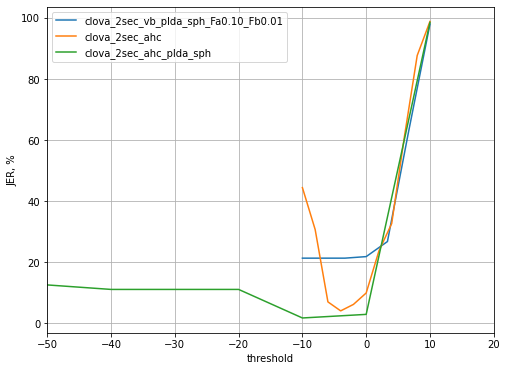

In [11]:
plt.figure(figsize=(8, 6))
plt.xlabel("threshold")
plt.ylabel("JER, %")
plt.xlim(-50, 20)
plt.grid() 


fa = 0.1
fb = 0.01

run_name = 'clova_2sec_vb_plda_sph'
    
results_dict_run = results_dict[run_name]
params_dict = results_dict_run['params']
Fa = params_dict["Fa"]
Fb = params_dict["Fb"]

mask = (Fa == fa) * (Fb == fb)

thresholds = params_dict['threshold']

JER = results_dict_run['JER']

label = f"{run_name}_Fa{fa:.2f}_Fb{fb:.2f}"

plt.plot(thresholds[mask], JER[mask], label=label);
plt.legend();





for run_name in ['clova_2sec_ahc', 'clova_2sec_ahc_plda_sph']:

    results_dict_run = results_dict[run_name]
    params_dict = results_dict_run['params']

    thresholds = params_dict['threshold']

    JER = results_dict_run['JER']

    label = f"{run_name}"

    plt.plot(thresholds[:], JER[:], label=label);
    plt.legend();     